In [1]:
#!rm -rf code
#!git clone https://xxxx/yyyy.git code
#!mv code/* .
%load_ext autoreload
%autoreload 2
%matplotlib inline
from helpers import *
from matplotlib import pyplot as plt
import numpy as np
from experiment_datasets import *
import pandas as pd
import seaborn as sns
import pickle
from IPython.display import clear_output
import matplotlib
from scipy.optimize import curve_fit

Using TensorFlow backend.


Initialized TensorFlow


### Fixed single Boston experiment for all dataset as points

In [2]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
# pfailure for the first layer
p = 1e-2
np.random.seed(42)

In [4]:
N = 50

/localhome/dfdf/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


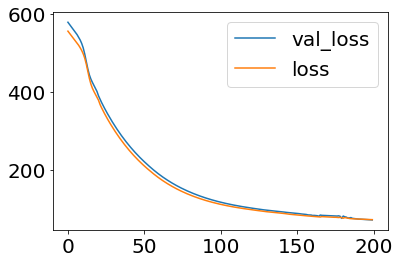

In [5]:
# Train a network with given h1 size and compute mean FT variance
K.clear_session()
    
# run with random weights and multiple inputs
exp = BostonHousingExperiment(N = [N, 49], p_inference = [0, p, 0, 0], seed = int(np.random.random() * 100000),
                                  activation = 'sigmoid', epochs = 200, do_print = 'plot',
                                  reg_coeff = 0, reg_type = 'l2')

In [6]:
# obtaining data points
data = exp.x_train, exp.y_train#exp.get_inputs_outputs('all')

In [7]:
var_loss = np.mean(exp._get_bound_b3_loss(*data)['std'] ** 2)
print('variance loss error', var_loss)

variance loss error 25.333652


(array([ 15.,  48.,  72., 120.,  64.,  31.,  21.,   8.,   8.,  17.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <a list of 10 Patch objects>)

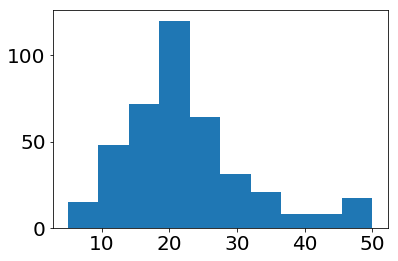

In [181]:
plt.hist(exp.y_train)

In [8]:
preact = exp.W[0] @ data[0].T + np.reshape(exp.B[0], (-1, 1))
y = exp.activation_fcn(preact)

In [9]:
y_norm_max = np.max(np.linalg.norm(y, axis = 0))

In [10]:
norm_prod = np.prod([np.linalg.norm(w) for w in exp.W[1:]])

In [179]:
norm_prod

62.6493

In [176]:
# TODO: do spectral bound for variance (now just estimate)
spectral_bound = p * norm_prod ** 2 * y_norm_max ** 2

In [177]:
spectral_bound

1255.8186658955244

In [14]:
### TODO: compute using Hoeffding what is the probability of too big error in weights?

Hoeffding's inequality [1]: for a set of random variables $x_i\in[0,a_i]$
$$
P(X\geq \mathbb{E}X+t)\leq \exp(\frac{-2t^2}{\sum a_i^2})
$$

[1] https://en.wikipedia.org/wiki/Hoeffding%27s_inequality

In [113]:
print('mean loss error', np.mean(exp._get_bound_b3_loss(*data)['mean']))

mean loss error 0.037543956


In [24]:
crash_weights = np.linalg.norm(exp.W[1], axis = 0) ** 2

(array([18., 24.,  4.,  2.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([1.3058146, 1.8190122, 2.3322098, 2.8454072, 3.358605 , 3.8718026,
        4.385    , 4.8981977, 5.411395 , 5.924593 , 6.4377904],
       dtype=float32),
 <a list of 10 Patch objects>)

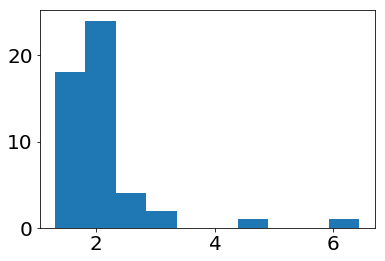

In [25]:
plt.hist(crash_weights)

In [27]:
d = len(crash_weights)

In [81]:
total = np.sum(crash_weights)

In [62]:
random_var = lambda : np.dot(crash_weights, np.random.rand(d) <= p)

In [110]:
repetitions = 100000

In [132]:
x = np.array([random_var() for _ in range(repetitions)])

In [133]:
np.mean(x)

1.0525943

(array([6.3366e+04, 2.6561e+04, 5.7190e+03, 2.3860e+03, 1.3580e+03,
        4.4500e+02, 1.0300e+02, 5.0000e+01, 1.0000e+01, 2.0000e+00]),
 array([ 0.       ,  1.4817454,  2.9634907,  4.445236 ,  5.9269814,
         7.4087267,  8.890472 , 10.372217 , 11.853963 , 13.335708 ,
        14.817453 ], dtype=float32),
 <a list of 10 Patch objects>)

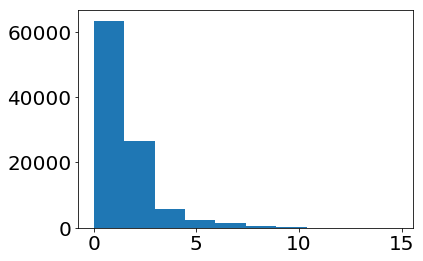

In [134]:
plt.hist(x)

In [158]:
threshold = 2
exp_proba = np.mean(x - np.mean(x) >= threshold)
print('P(x >= Ex + eps) <= delta')
print('eps =', threshold, 'delta =', exp_proba)

P(x >= Ex + eps) <= delta
eps = 2 delta = 0.09907


In [159]:
# Hoeffding bound -- not tight?
np.exp(-2 * threshold ** 2 / np.linalg.norm(crash_weights) ** 2)

0.9690530584023419

In [160]:
np.linalg.norm(crash_weights) ** 2

254.48600973597786

In [161]:
np.std(x) ** 2 / threshold ** 2

0.6284363095728764

In [162]:
# Chernoff:
x = 1. * np.random.rand(100000) <= p

In [165]:
random_var = lambda : np.dot(np.ones(d), np.random.rand(d) <= p)

0.49896


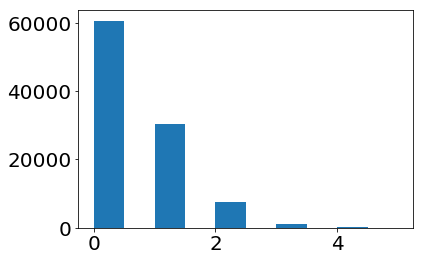

In [175]:
repetitions = 100000
x = np.array([random_var() for _ in range(repetitions)])
plt.hist(x)
print(np.mean(x))

**Statement 1:** as $n\to\infty$, there is a threshold after which $P(|U|^2\geq (\varepsilon+p)|W|^2)\leq e^{-\varepsilon^2 (|W|^2)^2/|W|^4}\sim e^{-\varepsilon^2 n}$, so this decays exponentially with $n$ and $|W_1|\cdot...\cdot|W_n|$ increases polynomially. So the "bad" part can be made arbitrarily small by choosing sufficient order of $n$

And this gives an estimate $n\sim 1/p^2$. Is this too much? How to get $1/p$?

Here it also must be true that $\varepsilon+p\approx\varepsilon$, in other words, it doesn't make sense to take $\varepsilon < p$.

Is it true that a more tight spectral bound is not required?

**Statement 2:** if the bad part is low enough, variance is linear in number of failed neurons: $Var\Delta\sim p/n$. So to make $P(\Delta + \mathbb{E}\Delta \geq L)\leq \frac{Var\Delta}{L^2}=\delta$ it is required to set
$$
n\geq p\frac{|W|^2\mathbb{E}_x|\frac{\partial L}{\partial W}|^2}{\delta L^2}
$$

Is it too pessimistic? Is Chernoff bound required?

For Chernoff, need to have $p_{bad}e^{\Delta_\max}<1$ which is exponential and unlikely... how to fix it? Otherwise can use linear Taylor and then it's easily computed. How to deal with $e^{rest}$? Can just say limit to $f/n<\alpha$, then still can have Taylor remainder...

For $\alpha^2$: Need to show that $\alpha^2 |L''|$ is small... And for that need $\alpha\sim 1/|L''|$.